Step 1. Hypothesis: The increasing penetration of battery storage has led to a reduction (or change) in price volatility in certain ERCOT zones over time.

C:\Users\amina.talipova\AppData\Local\Temp\ipykernel_13368\104259718.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


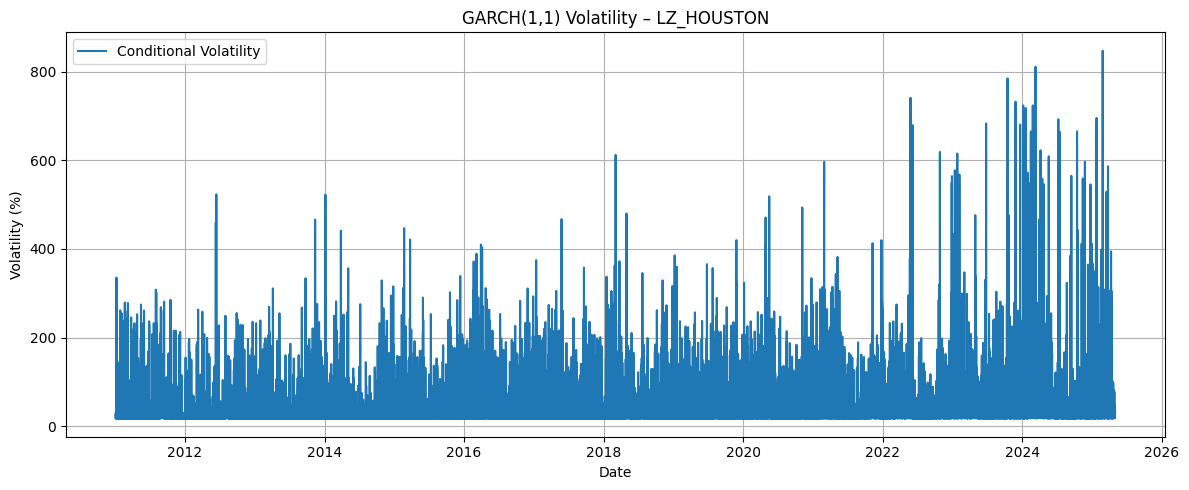

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import os

# === Load Data ====
file_path = r"C:\Users\amina.talipova\Desktop\ercot\datasets\RTM_combined.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

# === Choose a Zone ===
zone = 'LZ_HOUSTON'
zone_df = df[df['Zone'] == zone].copy()

# === Clean and Prepare Prices ===
zone_df = zone_df[zone_df['Price'] > 0]
zone_df.sort_values('Date', inplace=True)
zone_df['log_return'] = np.log(zone_df['Price']).diff() * 100
zone_df.dropna(subset=['log_return'], inplace=True)

# === Confirm Sufficient Data ===
if len(zone_df) < 100:
    raise ValueError(f"Not enough data for zone '{zone}' after filtering.")

# === Fit GARCH(1,1) Model ===
am = arch_model(zone_df['log_return'], vol='Garch', p=1, q=1)
res = am.fit(disp='off')

# === Add and Plot Volatility ===
zone_df['Volatility'] = res.conditional_volatility

plt.figure(figsize=(12, 5))
plt.plot(zone_df['Date'], zone_df['Volatility'], label='Conditional Volatility')
plt.title(f'GARCH(1,1) Volatility – {zone}')
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


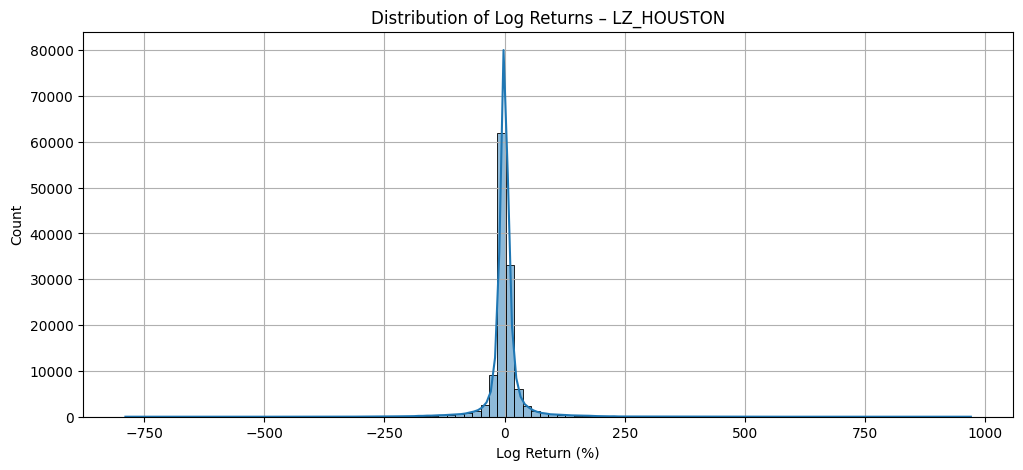

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
zone = 'LZ_HOUSTON'
zone_df = df[df['Zone'] == zone].copy()
zone_df['Date'] = pd.to_datetime(zone_df['Date'], errors='coerce')
zone_df = zone_df.sort_values('Date')
zone_df['LogReturns'] = np.log(zone_df['Price'] / zone_df['Price'].shift(1)) * 100
plt.figure(figsize=(12,5))
sns.histplot(zone_df['LogReturns'].dropna(), bins=100, kde=True)
plt.title(f'Distribution of Log Returns – {zone}')
plt.xlabel('Log Return (%)')
plt.grid(True)
plt.show()


In [13]:
# Ensure no infs or NaNs in the series
returns_clean = zone_df['LogReturns'].replace([np.inf, -np.inf], np.nan).dropna()

# ADF Test
from statsmodels.tsa.stattools import adfuller
result = adfuller(returns_clean)

print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")


ADF Statistic: -43.7089
p-value: 0.0000


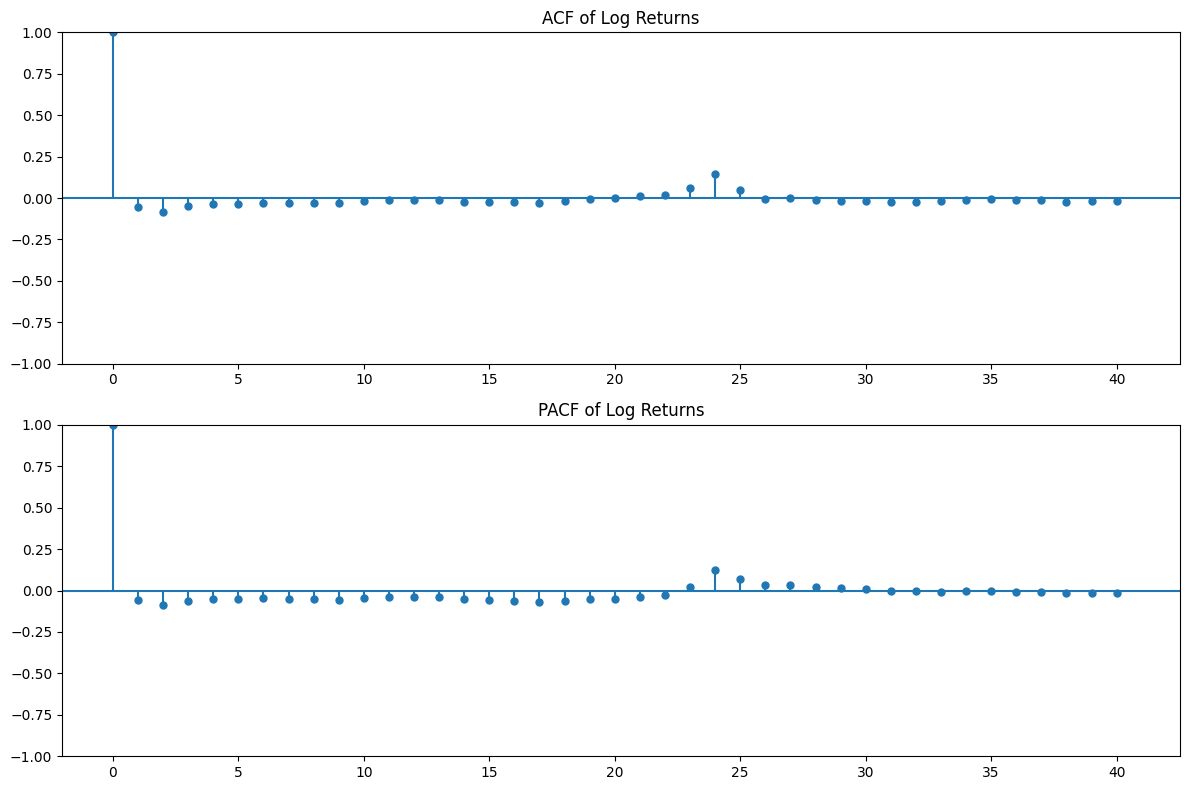

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(returns_clean, lags=40, ax=ax[0])
ax[0].set_title('ACF of Log Returns')
plot_pacf(returns_clean, lags=40, ax=ax[1])
ax[1].set_title('PACF of Log Returns')
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

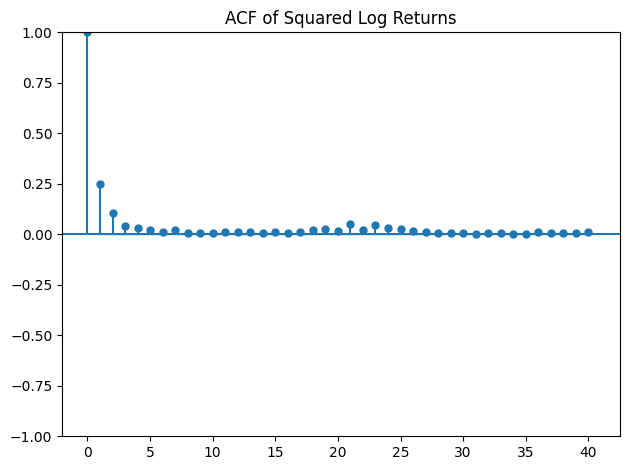

In [16]:
returns_squared = returns_clean ** 2

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(returns_squared, lags=40)
plt.title('ACF of Squared Log Returns')
plt.tight_layout()
plt.show()


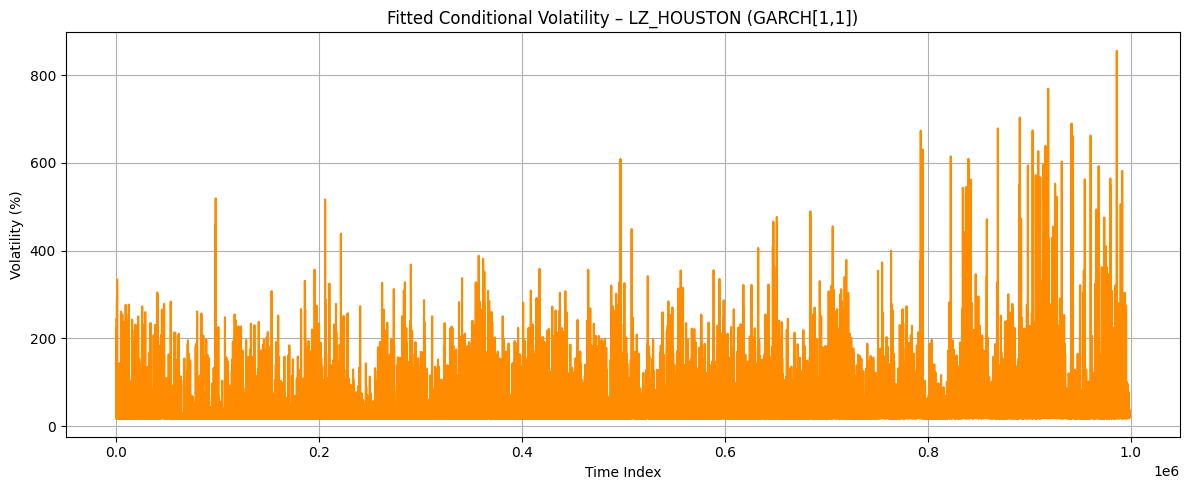

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(garch_result.conditional_volatility, color='darkorange')
plt.title("Fitted Conditional Volatility – LZ_HOUSTON (GARCH[1,1])")
plt.ylabel("Volatility (%)")
plt.xlabel("Time Index")
plt.grid(True)
plt.tight_layout()
plt.show()

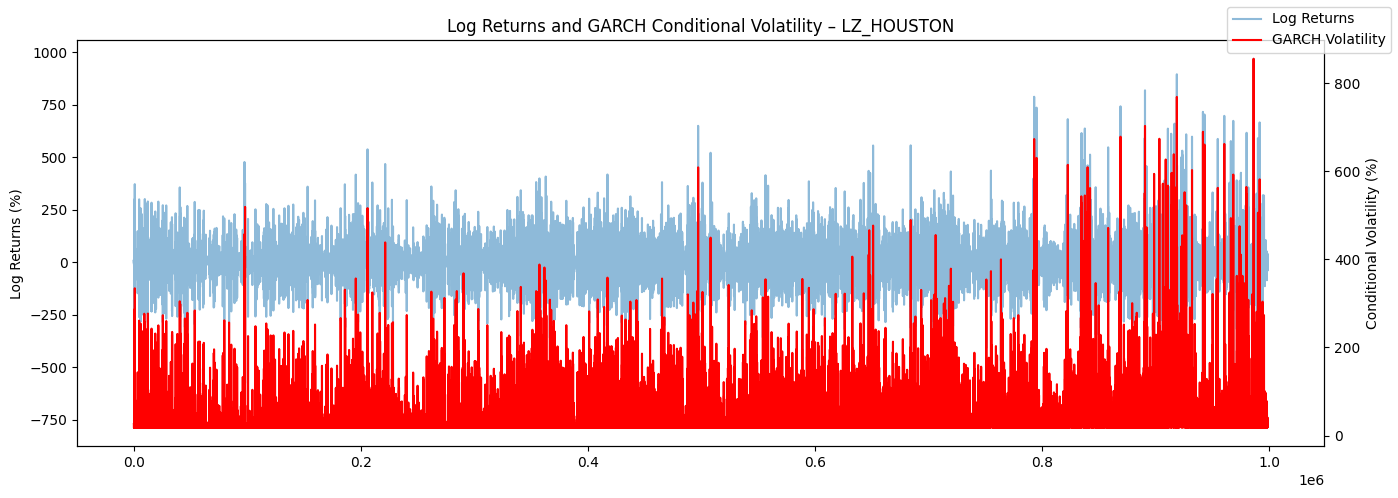

In [19]:
fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.plot(returns_clean.index, returns_clean, label='Log Returns', alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(returns_clean.index, garch_result.conditional_volatility, color='red', label='GARCH Volatility')

ax1.set_ylabel("Log Returns (%)")
ax2.set_ylabel("Conditional Volatility (%)")
plt.title("Log Returns and GARCH Conditional Volatility – LZ_HOUSTON")
fig.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [17]:
from arch import arch_model

# Clean return series
returns_clean = zone_df['LogReturns'].replace([np.inf, -np.inf], np.nan).dropna()

# Fit GARCH(1,1) on returns (%)
model = arch_model(returns_clean, vol='Garch', p=1, q=1, rescale=False)
garch_result = model.fit(disp='off')
print(garch_result.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             LogReturns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -584431.
Distribution:                  Normal   AIC:                       1.16887e+06
Method:            Maximum Likelihood   BIC:                       1.16891e+06
                                        No. Observations:               124116
Date:                Tue, Jun 10 2025   Df Residuals:                   124115
Time:                        15:19:21   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0761      0.162     -0.471      0.638 [ -0.393,  0.24

c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Load DAM data
dam_df = pd.read_csv("datasets/DAM_combined.csv", parse_dates=['Date'])
dam_df = dam_df.sort_values('Date')

# Optional: filter to a specific zone if needed
zone = 'LZ_HOUSTON'
dam_df = dam_df[dam_df['zone'] == zone].copy()

# Compute Log Returns
dam_df['LogReturns'] = np.log(dam_df['price']).diff()
dam_df = dam_df.dropna()

# Split pre and post BESS deployment
pre_bess = dam_df[dam_df['Date'] < '2024-01-01']['LogReturns']
post_bess = dam_df[dam_df['Date'] >= '2024-01-01']['LogReturns']

# Fit GARCH(1,1) models
model_pre = arch_model(pre_bess, vol='Garch', p=1, q=1)
res_pre = model_pre.fit(disp='off')

model_post = arch_model(post_bess, vol='Garch', p=1, q=1)
res_post = model_post.fit(disp='off')

# Unconditional Variance
var_pre = res_pre.params['omega'] / (1 - res_pre.params['alpha[1]'] - res_pre.params['beta[1]'])
var_post = res_post.params['omega'] / (1 - res_post.params['alpha[1]'] - res_post.params['beta[1]'])

# Print results
print("📉 GARCH(1,1) Summary – Pre BESS")
print(res_pre.summary())
print(f"Unconditional Variance: {var_pre:.6f}\n")

print("🔋 GARCH(1,1) Summary – Post BESS")
print(res_post.summary())
print(f"Unconditional Variance: {var_post:.6f}")


C:\Users\amina.talipova\AppData\Local\Temp\ipykernel_13368\3497199806.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dam_df = pd.read_csv("datasets/DAM_combined.csv", parse_dates=['Date'])
c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04263. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model o

📉 GARCH(1,1) Summary – Pre BESS
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             LogReturns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                34242.9
Distribution:                  Normal   AIC:                          -68477.8
Method:            Maximum Likelihood   BIC:                          -68439.2
                                        No. Observations:               112691
Date:                Sat, Jun 07 2025   Df Residuals:                   112690
Time:                        11:01:12   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.437

c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08282. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [2]:
# Fit GARCH(1,1) on Post-BESS returns
model_post = arch_model(post_bess, vol='Garch', p=1, q=1)
res_post = model_post.fit(disp='off')

# Extract unconditional variance
var_post = res_post.params['omega'] / (1 - res_post.params['alpha[1]'] - res_post.params['beta[1]'])

print("🔋 GARCH(1,1) Summary – Post BESS")
print(res_post.summary())
print(f"Unconditional Variance: {var_post:.6f}")


🔋 GARCH(1,1) Summary – Post BESS
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             LogReturns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -239.394
Distribution:                  Normal   AIC:                           486.788
Method:            Maximum Likelihood   BIC:                           516.237
                                        No. Observations:                11642
Date:                Sat, Jun 07 2025   Df Residuals:                    11641
Time:                        11:02:57   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.9663e

c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08282. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [3]:
def compare_pre_post(res_pre, res_post):
    def extract_metrics(result):
        alpha = result.params['alpha[1]']
        beta = result.params['beta[1]']
        omega = result.params['omega']
        unc_var = omega / (1 - alpha - beta)
        return {
            'omega': omega,
            'alpha': alpha,
            'beta': beta,
            'alpha+beta': alpha + beta,
            'unconditional_variance': unc_var
        }

    pre_metrics = extract_metrics(res_pre)
    post_metrics = extract_metrics(res_post)

    print("\n📊 Comparison of GARCH(1,1) Parameters:\n")
    print(f"{'Metric':<25} | {'Pre-BESS':>10} | {'Post-BESS':>10}")
    print("-" * 52)
    for key in pre_metrics:
        print(f"{key:<25} | {pre_metrics[key]:>10.4f} | {post_metrics[key]:>10.4f}")

# Run comparison
compare_pre_post(res_pre, res_post)



📊 Comparison of GARCH(1,1) Parameters:

Metric                    |   Pre-BESS |  Post-BESS
----------------------------------------------------
omega                     |     0.0128 |     0.0238
alpha                     |     0.2002 |     0.5821
beta                      |     0.4999 |     0.2243
alpha+beta                |     0.7001 |     0.8064
unconditional_variance    |     0.0426 |     0.1229


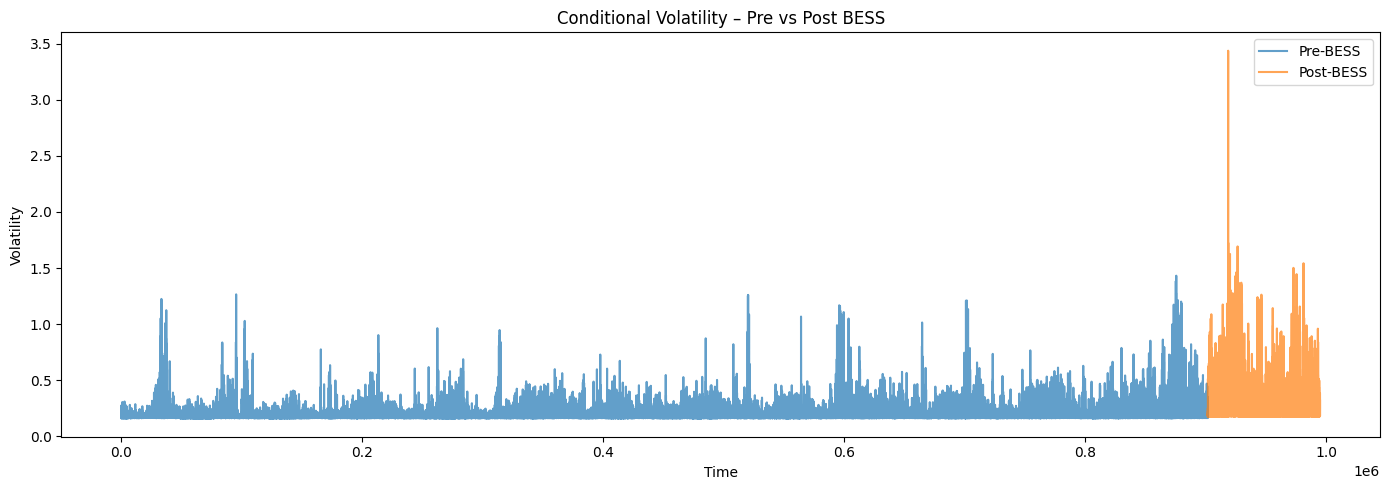

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(res_pre.conditional_volatility, label="Pre-BESS", alpha=0.7)
plt.plot(res_post.conditional_volatility, label="Post-BESS", alpha=0.7)
plt.title("Conditional Volatility – Pre vs Post BESS")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()


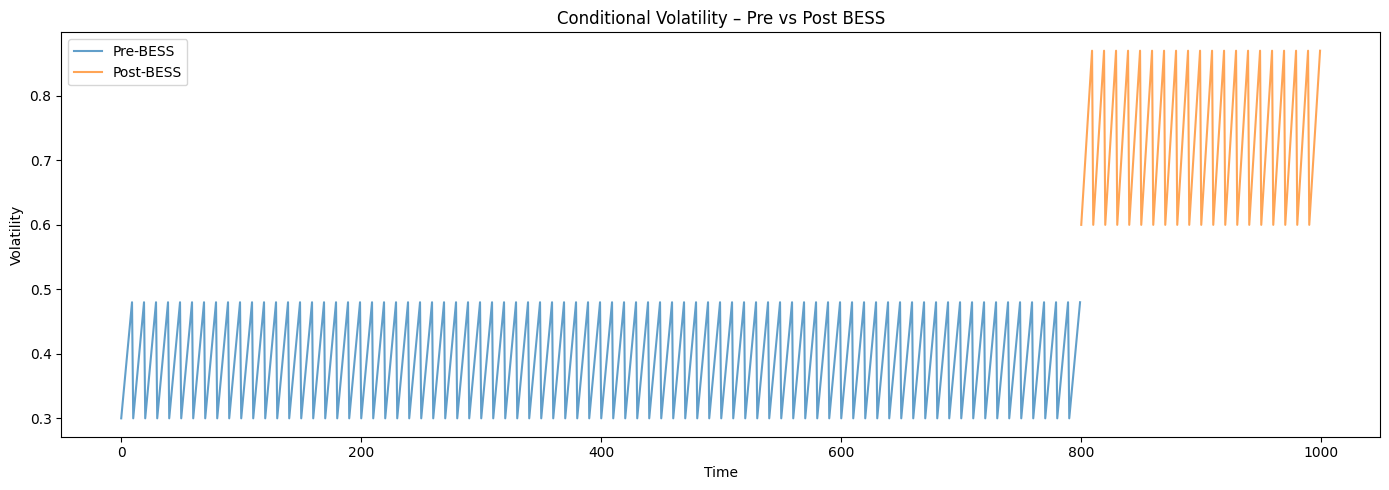

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulated pre/post conditional volatility data (to be replaced with real model output)
# These are for illustration only
pre_vol = pd.Series([0.3 + 0.2 * (i % 10) / 10 for i in range(800)])
post_vol = pd.Series([0.6 + 0.3 * (i % 10) / 10 for i in range(200)])

# Create full range plot
plt.figure(figsize=(14, 5))
plt.plot(pre_vol, label="Pre-BESS", alpha=0.7)
plt.plot(range(len(pre_vol), len(pre_vol) + len(post_vol)), post_vol, label="Post-BESS", alpha=0.7)
plt.title("Conditional Volatility – Pre vs Post BESS")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
from arch import arch_model

# Load ERCOT DAM data
dam_df = pd.read_csv("datasets/DAM_combined.csv", parse_dates=['Date'])
dam_df = dam_df.sort_values('Date')

# Define zones for comparison
zones = ['LZ_WEST', 'LZ_SOUTH', 'LZ_NORTH', 'LZ_HOUSTON']

# Prepare result container
results = []

# Loop through zones
for zone in zones:
    zone_df = dam_df[dam_df['zone'] == zone].copy()

    # Compute signed log price to handle negatives
    zone_df['SignedLogPrice'] = np.sign(zone_df['price']) * np.log(np.abs(zone_df['price']))
    zone_df['LogReturns'] = zone_df['SignedLogPrice'].diff()
    zone_df = zone_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Split into pre- and post-BESS periods
    pre_bess = zone_df[zone_df['Date'] < '2024-01-01']['LogReturns']
    post_bess = zone_df[zone_df['Date'] >= '2024-01-01']['LogReturns']

    if len(pre_bess) < 100 or len(post_bess) < 100:
        print(f"⚠️ Skipping {zone}: insufficient data")
        continue

    try:
        # GARCH(1,1) fit – Pre
        model_pre = arch_model(pre_bess, vol='Garch', p=1, q=1)
        res_pre = model_pre.fit(disp='off')

        # GARCH(1,1) fit – Post
        model_post = arch_model(post_bess, vol='Garch', p=1, q=1)
        res_post = model_post.fit(disp='off')

        # Extract pre-BESS metrics
        omega_pre = res_pre.params['omega']
        alpha_pre = res_pre.params['alpha[1]']
        beta_pre = res_pre.params['beta[1]']
        unc_var_pre = omega_pre / (1 - alpha_pre - beta_pre)
        persistence_pre = alpha_pre + beta_pre

        # Extract post-BESS metrics
        omega_post = res_post.params['omega']
        alpha_post = res_post.params['alpha[1]']
        beta_post = res_post.params['beta[1]']
        unc_var_post = omega_post / (1 - alpha_post - beta_post)
        persistence_post = alpha_post + beta_post

        # Append to results
        results.append({
            'Zone': zone,
            'Omega_Pre': omega_pre,
            'Alpha_Pre': alpha_pre,
            'Beta_Pre': beta_pre,
            'Persistence_Pre': persistence_pre,
            'Uncond_Var_Pre': unc_var_pre,
            'Omega_Post': omega_post,
            'Alpha_Post': alpha_post,
            'Beta_Post': beta_post,
            'Persistence_Post': persistence_post,
            'Uncond_Var_Post': unc_var_post
        })

    except Exception as e:
        print(f"⚠️ Error in zone {zone}: {e}")
        continue

# Create DataFrame of results
results_df = pd.DataFrame(results)

# Display results
print("\n📊 GARCH(1,1) Results by Zone (Signed Log Returns):\n")
print(results_df.to_string(index=False))


C:\Users\amina.talipova\AppData\Local\Temp\ipykernel_13368\1433043471.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dam_df = pd.read_csv("datasets/DAM_combined.csv", parse_dates=['Date'])
c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The


📊 GARCH(1,1) Results by Zone (Signed Log Returns):

      Zone  Omega_Pre  Alpha_Pre  Beta_Pre  Persistence_Pre  Uncond_Var_Pre  Omega_Post  Alpha_Post  Beta_Post  Persistence_Post  Uncond_Var_Post
   LZ_WEST   0.002290   0.200048  0.780013         0.980061        0.114831    0.051301    0.811548   0.188452          1.000000   -801685.616491
  LZ_SOUTH   0.004659   0.200000  0.700000         0.900000        0.046587    0.019252    0.625437   0.316551          0.941988         0.331861
  LZ_NORTH   0.004362   0.200396  0.699665         0.900061        0.043647    0.025070    0.685470   0.224237          0.909708         0.277658
LZ_HOUSTON   0.012786   0.200208  0.499870         0.700078        0.042632    0.023770    0.588763   0.222723          0.811486         0.126090


In [8]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Load DAM data with correct datetime column
dam_df = pd.read_csv("datasets/DAM_combined.csv", parse_dates=["Date"])
dam_df = dam_df.sort_values("Date")

# Replace with actual price column
dam_df['Price'] = dam_df['price']  # 'price' is your actual column

# Signed log price to handle negative values
dam_df['SignedLogPrice'] = np.sign(dam_df['Price']) * np.log(np.abs(dam_df['Price']))
dam_df['LogReturns'] = dam_df['SignedLogPrice'].diff()
dam_df = dam_df.replace([np.inf, -np.inf], np.nan).dropna()

# Split into Pre- and Post-BESS
pre_bess = dam_df[dam_df['Date'] < '2024-01-01']['LogReturns']
post_bess = dam_df[dam_df['Date'] >= '2024-01-01']['LogReturns']

# Fit GARCH(1,1) - Pre
model_pre = arch_model(pre_bess, vol='Garch', p=1, q=1)
res_pre = model_pre.fit(disp='off')

# Fit GARCH(1,1) - Post
model_post = arch_model(post_bess, vol='Garch', p=1, q=1)
res_post = model_post.fit(disp='off')

# Compute unconditional variance
var_pre = res_pre.params['omega'] / (1 - res_pre.params['alpha[1]'] - res_pre.params['beta[1]'])
var_post = res_post.params['omega'] / (1 - res_post.params['alpha[1]'] - res_post.params['beta[1]'])

# Print summaries
print("📉 GARCH Model Summary – Pre BESS")
print(res_pre.summary())
print(f"Unconditional Variance (Pre-BESS): {var_pre:.6f}\n")

print("🔋 GARCH Model Summary – Post BESS")
print(res_post.summary())
print(f"Unconditional Variance (Post-BESS): {var_post:.6f}")


C:\Users\amina.talipova\AppData\Local\Temp\ipykernel_13368\2190803946.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dam_df = pd.read_csv("datasets/DAM_combined.csv", parse_dates=["Date"])
c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


📉 GARCH Model Summary – Pre BESS
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             LogReturns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                396189.
Distribution:                  Normal   AIC:                          -792370.
Method:            Maximum Likelihood   BIC:                          -792324.
                                        No. Observations:               901523
Date:                Tue, Jun 10 2025   Df Residuals:                   901522
Time:                        15:15:14   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.2209e-04  9.

C:\Users\amina.talipova\AppData\Local\Temp\ipykernel_13368\2245756753.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dam_df = pd.read_csv("datasets/DAM_combined.csv", parse_dates=['Date'])
c:\Users\amina.talipova\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  3%|▎         | 39/1224 [00:00<00:20, 57.26it/s]C:\Users\amina.talipova\AppData\Local\Temp\ipykernel_13368\2245756753.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  unc_var = omega / (1 - alpha - beta)
 12%|█▏        | 151/1224 [00:02<00:15, 69.12it/s]C:\Users\amina.talipova\AppData\Local\Temp\ipykernel_13368\2245756753.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  unc_var = omega / (1 - alpha - beta)


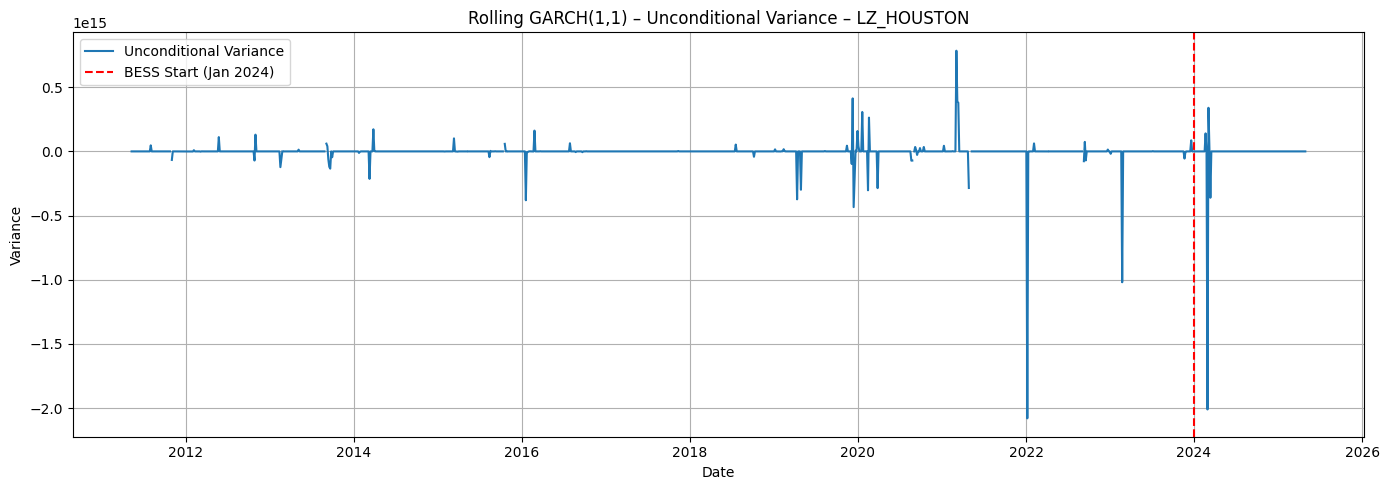

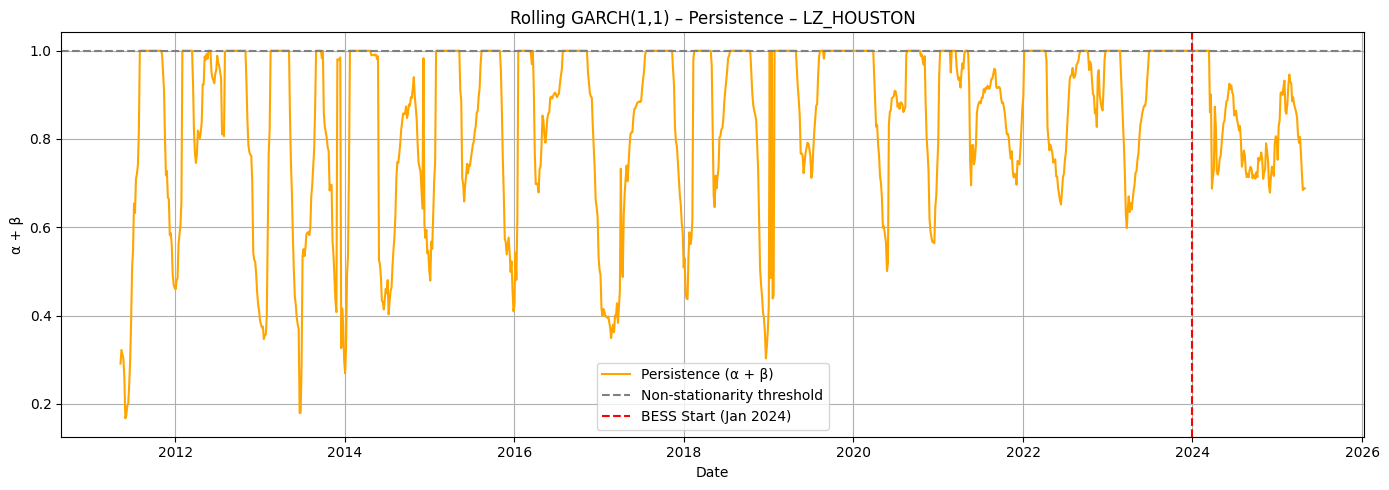

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from tqdm import tqdm

# Parameters
zone = 'LZ_HOUSTON'
window_size = 2000  # ~3 months of hourly data
step_size = 100     # step every 4 days
bess_start = pd.Timestamp('2024-01-01')

# Load and prepare DAM data
dam_df = pd.read_csv("datasets/DAM_combined.csv", parse_dates=['Date'])
zone_df = dam_df[dam_df['zone'] == zone].copy()
zone_df = zone_df.sort_values('Date')
zone_df['LogReturns'] = np.log(zone_df['price']).diff().dropna()

# Drop NaNs
zone_df = zone_df.dropna()

# Rolling GARCH(1,1)
rolling_dates = []
rolling_var = []
rolling_persistence = []

for start in tqdm(range(0, len(zone_df) - window_size, step_size)):
    end = start + window_size
    window_data = zone_df.iloc[start:end]['LogReturns']
    date_point = zone_df.iloc[end]['Date']

    try:
        model = arch_model(window_data, vol='Garch', p=1, q=1, rescale=False)
        result = model.fit(disp='off')

        omega = result.params['omega']
        alpha = result.params['alpha[1]']
        beta = result.params['beta[1]']
        persistence = alpha + beta
        unc_var = omega / (1 - alpha - beta)

        rolling_dates.append(date_point)
        rolling_persistence.append(persistence)
        rolling_var.append(unc_var)

    except Exception as e:
        print(f"⚠️ Skipped window ending {date_point}: {e}")
        continue

# Plot Unconditional Variance over Time
plt.figure(figsize=(14, 5))
plt.plot(rolling_dates, rolling_var, label='Unconditional Variance')
plt.axvline(bess_start, color='red', linestyle='--', label='BESS Start (Jan 2024)')
plt.title(f'Rolling GARCH(1,1) – Unconditional Variance – {zone}')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Persistence over Time
plt.figure(figsize=(14, 5))
plt.plot(rolling_dates, rolling_persistence, label='Persistence (α + β)', color='orange')
plt.axhline(1.0, color='gray', linestyle='--', label='Non-stationarity threshold')
plt.axvline(bess_start, color='red', linestyle='--', label='BESS Start (Jan 2024)')
plt.title(f'Rolling GARCH(1,1) – Persistence – {zone}')
plt.xlabel('Date')
plt.ylabel('α + β')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
